# Quick start

This tutorial will show how to use the pseodo batch transformation function in python and explain the data structure of the input data.

## Loading fedbatch data
We will start with setting up the python session and loading the data.

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pseudobatch import pseudobatch_transform_pandas, pseudobatch_transform
from pseudobatch.datasets import load_standard_fedbatch

The pseudobatch package includes few datasets of simulated data that are used to showcase the package. We will load the simplest one which is a exponential fed-batch fermentation operated in substrate limited mode.

In [19]:
fedbatch_df = load_standard_fedbatch(sampling_points_only=True)

Lets start with getting an overview of the data that we have imported by looking at a part of the dataframe.

In [20]:
(fedbatch_df
    .filter(['sample_volume', 'timestamp', 'c_Biomass', 'c_Glucose', 'c_Product', 'v_Volume', 'v_Feed_accum'])
)

,sample_volume,timestamp,c_Biomass,c_Glucose,c_Product,v_Volume,v_Feed_accum
0,170.0,10.000000,1.337852,0.075016,0.694735,1015.906036,15.906036
1,170.0,17.142857,2.664023,0.075103,1.794378,867.753513,37.753513
2,170.0,24.285714,5.175767,0.075053,3.877080,733.638872,73.638872
3,170.0,31.428571,9.612284,0.075015,7.555778,619.956743,129.956743
4,170.0,38.571429,16.561967,0.075011,13.318358,533.452797,213.452797
5,170.0,45.714286,25.635276,0.075009,20.841818,479.658734,329.658734
6,170.0,52.857143,35.029969,0.075033,28.631766,462.904906,482.904906
7,170.0,60.000000,42.688520,0.075012,34.982129,490.982268,680.982268


This shows some of the columns in the dataframe. 

- `sample_volume` columns contain the sample volume at the given time point. In this dataset, we have online measurements thus more measurements than samples and therefore at most timepoint the sample volume is 0.
- `timestamp` describe the timepoint
- `c_Biomass`, `c_Glucose`, and `c_Product` is the online concentration measurements 
- `v_Volume` is the volume of the bioreactor. **IMPORTANT:** at points where a sample is taken this value represents the volume just **before** the sample was drawn.
- `v_Feed_accum` is the accumulated feed added until that timepoint.

This is also the data structure which the `pseudobatch_transform()` expects.

## Transform a single measurement time series
We will now transform the biomass time series data using the `pseudobatch_transform()` function.

In [21]:
pseudo_biomass = pseudobatch_transform(
    measured_concentration=fedbatch_df['c_Biomass'].to_numpy(),
    reactor_volume=fedbatch_df['v_Volume'].to_numpy(),
    accumulated_feed=fedbatch_df['v_Feed_accum'].to_numpy(),
    concentration_in_feed=0, # There is no biomass in the feeding medium 
    sample_volume=fedbatch_df['sample_volume'].to_numpy()
)

## Transform multiple time series

The above show how to transform measurements from a single species (here biomass). However often fermentation datasets often also holds measurements substrate and products, and by-products.

We expect most users to work with their data in Pandas Dataframes therefore provide a convenience wrapper function that can be applied directly to a Pandas DataFrame. Under the hood this just loops over a list of columns and calls the `pseudobatch_transform()` on each of them. Because we provide a list of species to transform, we also need to provide a list of concentrations in the feed medium. The two lists has to follow the same order.

In [22]:
conc_in_feed = [0, 100, 0] # [Biomass, Glucose, Product] in g/L

fedbatch_df[["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo"]] = pseudobatch_transform_pandas(
    fedbatch_df,
    measured_concentration_colnames=["c_Biomass", "c_Glucose", "c_Product"],
    reactor_volume_colname="v_Volume",
    accumulated_feed_colname="v_Feed_accum",
    sample_volume_colname="sample_volume",
    concentration_in_feed=conc_in_feed,
)

**Note 1** In the above, we show how to transform data from a single culture/replicate. In [this tutorial](httpsss/biosustain.github.io/pseudobatch/Tutorials/6%20-%20Real%20data%20example%3A%20Yeast%20Biolector%20Fermentation.html) we show how transform multiple cultures in one go using the Pandas groupby functionality.

**Note 2** Volatile compounds (for example CO2 and O2) requires special treatment, find more about that in [this tutorial](https://biosustain.github.io/pseudobatch/Tutorials/8%20-%20Special%20case%20gaseous%20species.html).

Now we have the pseudo-batch transformed data.

In [23]:
fedbatch_df.filter(['timestamp', "c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo"]).head()

,timestamp,c_Biomass_pseudo,c_Glucose_pseudo,c_Product_pseudo
0,10.000000,1.337852,0.075016,0.694735
1,17.142857,2.732828,-2.505689,1.840722
2,24.285714,5.582507,-7.777595,4.181762
3,31.428571,11.403591,-18.546600,8.963843
4,38.571429,23.294434,-40.544661,18.732292


## Visualizing the pseudobatch concentrations

We can quickly visualize the data here

Text(0.5, 0, 'Time [h]')

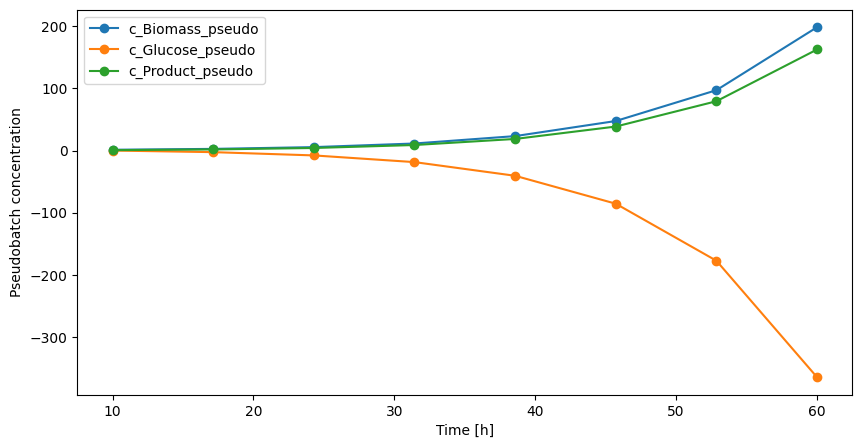

In [24]:
fedbatch_df.plot(
    x="timestamp", 
    y=["c_Biomass_pseudo", "c_Glucose_pseudo", "c_Product_pseudo"], 
    marker="o",
    figsize=(10, 5)
)
plt.ylabel("Pseudobatch concentration")
plt.xlabel("Time [h]")

In pseudo batch transformed data consumed species typically becomes negative. This simply shows that the culture have consumed more glucose than was initially present because of the feed. To make a prettier plot we can simply subtract the final pseudo batch concentration from all measurements.

Text(0.5, 0, 'Time [h]')

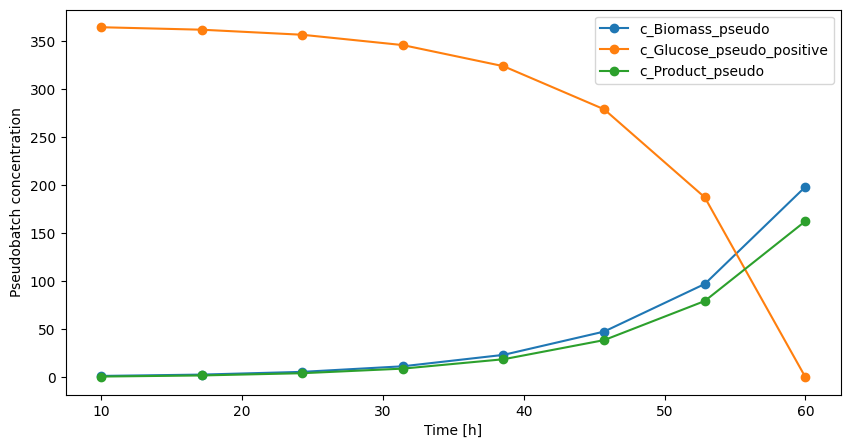

In [25]:
fedbatch_df["c_Glucose_pseudo_positive"] = fedbatch_df["c_Glucose_pseudo"] - fedbatch_df["c_Glucose_pseudo"].iloc[-1]
fedbatch_df.plot(
    x="timestamp", 
    y=["c_Biomass_pseudo", "c_Glucose_pseudo_positive", "c_Product_pseudo"], 
    marker="o",
    figsize=(10, 5)
)
plt.ylabel("Pseudobatch concentration")
plt.xlabel("Time [h]")

Now the data also looks more like what we usually expect from a batch culture. Remember that the y-axis has the units pseudo concentration, thus it is difficult to interpret the actual values. It is safest to only interpret time evolution trends of the pseudo batch concentration data.

This quick start only shows how to use the pseudo batch transformation. In the tutorials you will find examples of how to integrate the pseudo batch transformation into regular cell cultivation workflows.